# 01 - Limpieza y Exploración Inicial: Steam Games Dataset

**Objetivo**: Cargar, inspeccionar y limpiar el dataset de juegos de Steam para dejarlo listo para análisis posteriores.

**Dataset**: [Steam Games Dataset - Kaggle](https://www.kaggle.com/datasets/fronkongames/steam-games-dataset)  
**Fuente**: Steam API + Steam Spy  
**Tamaño**: ~122,000 juegos, formato JSON  
**Archivo esperado**: `data/raw/games.json`

## Estructura del Dataset

| Campo | Tipo | Descripción |
|---|---|---|
| AppID | str (key) | Identificador único de Steam |
| name | str | Nombre del juego |
| release_date | str | Fecha de lanzamiento |
| price | float | Precio en USD |
| required_age | int | Restricción de edad |
| estimated_owners | str | Rango estimado de propietarios |
| peak_ccu | int | Usuarios concurrentes máximos |
| positive | int | Reviews positivas |
| negative | int | Reviews negativas |
| score_rank | str | Ranking por reviews |
| metacritic_score | int | Puntuación Metacritic |
| recommendations | int | Recomendaciones de usuarios |
| dlc_count | int | Cantidad de DLCs |
| achievements | int | Cantidad de logros |
| windows | bool | Soporte Windows |
| mac | bool | Soporte Mac |
| linux | bool | Soporte Linux |
| categories | list[dict] | Categorías del juego |
| genres | list[dict] | Géneros del juego |
| tags | dict | Tags con votos de usuarios |
| developers | list[str] | Desarrolladores |
| publishers | list[str] | Publicadores |
| average_playtime_forever | int | Tiempo promedio de juego (minutos) |
| supported_languages | str | Idiomas soportados |

---

## 0. Setup e Imports

In [ ]:
import sys
import json
import logging
from pathlib import Path
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# ---------------------------------------------------------------------------
# Detección de la raíz del proyecto (centralizada en src/utils/paths)
# ---------------------------------------------------------------------------
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # python-dotenv es opcional

# Fallback: asegurar que src/ esté en sys.path antes de importar
for _candidate in [Path.cwd().parent.parent, Path.cwd().parent, Path.cwd()]:
    if (_candidate / "src").is_dir():
        sys.path.insert(0, str(_candidate))
        break

from src.utils.paths import get_project_root, get_data_dirs
from src.data.loader import load_data
from src.data.steam_transforms import (
    extract_list_names,
    extract_tags_top,
    parse_languages,
    parse_owners_midpoint,
)
from src.visualization.plots import set_style, plot_distribution, plot_correlation

PROJECT_ROOT = get_project_root()
dirs = get_data_dirs(PROJECT_ROOT)

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Estilo visual del proyecto
set_style()

# Rutas del proyecto
RAW_DATA_DIR = dirs['raw']
PROCESSED_DATA_DIR = dirs['processed']
FIGURES_DIR = dirs['figures']

# Crear directorios si no existen
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f'Proyecto raiz: {PROJECT_ROOT}')
print(f'Datos raw: {RAW_DATA_DIR}')
print(f'Datos procesados: {PROCESSED_DATA_DIR}')
print(f'Figuras: {FIGURES_DIR}')

## 1. Carga del Dataset

El dataset `games.json` de Kaggle tiene una estructura de diccionario donde cada clave es el `AppID` del juego. Lo cargamos manualmente con `json` para controlar la expansión.

In [ ]:
def load_steam_json(filepath: Path) -> pd.DataFrame:
    """Carga el archivo games.json de Steam y lo convierte a DataFrame.
    
    El JSON tiene estructura {AppID: {campos del juego...}}.
    Convierte el AppID en columna y aplana el nivel superior.
    
    Args:
        filepath: Ruta al archivo games.json
        
    Returns:
        DataFrame con una fila por juego y AppID como columna.
    """
    logger.info(f'Cargando dataset desde: {filepath}')
    
    with open(filepath, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    logger.info(f'Total de juegos en JSON: {len(raw_data):,}')
    
    # Convertir a lista de registros con AppID incluido
    records = []
    for app_id, game_data in raw_data.items():
        record = {'AppID': app_id}
        record.update(game_data)
        records.append(record)
    
    df = pd.DataFrame(records)
    logger.info(f'DataFrame creado: {df.shape[0]:,} filas x {df.shape[1]} columnas')
    return df


# Cargar el dataset
json_path = RAW_DATA_DIR / 'games.json'

if not json_path.exists():
    print(f'AVISO: No se encontro el archivo en {json_path}')
    print('Descarga el dataset desde:')
    print('https://www.kaggle.com/datasets/fronkongames/steam-games-dataset')
    print('y coloca games.json en data/raw/')
    # Crear un DataFrame de muestra para demostrar el pipeline
    df_raw = pd.DataFrame({
        'AppID': ['570', '730', '440'],
        'name': ['Dota 2', 'Counter-Strike 2', 'Team Fortress 2'],
        'release_date': ['2013-07-09', '2012-08-21', '2007-10-10'],
        'price': [0.0, 0.0, 0.0],
        'positive': [1200000, 800000, 650000],
        'negative': [150000, 120000, 80000],
        'windows': [True, True, True],
        'mac': [True, True, True],
        'linux': [True, True, True],
        'metacritic_score': [90, 0, 92],
        'genres': [['Action', 'Strategy'], ['Action'], ['Action']],
        'developers': [['Valve'], ['Valve'], ['Valve']],
        'publishers': [['Valve'], ['Valve'], ['Valve']],
        'estimated_owners': ['50000000 - 100000000', '50000000 - 100000000', '10000000 - 20000000'],
        'average_playtime_forever': [500, 1200, 300],
        'peak_ccu': [300000, 700000, 50000],
        'dlc_count': [0, 0, 0],
        'achievements': [0, 167, 520],
        'required_age': [0, 0, 0],
        'categories': [['Multi-player', 'Co-op'], ['Multi-player'], ['Multi-player', 'Co-op']],
        'tags': [{'MOBA': 500}, {'FPS': 800}, {'Team-Based': 400}],
        'supported_languages': ['English, Spanish, French', 'English, Spanish', 'English'],
        'score_rank': ['', '', ''],
        'recommendations': [500000, 300000, 200000]
    })
    print('\nDataFrame de muestra creado para demostracion del pipeline.')
else:
    df_raw = load_steam_json(json_path)

print(f'\nShape del dataset: {df_raw.shape}')

INFO: Cargando dataset desde: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\raw\games.json


INFO: Total de juegos en JSON: 122,611


INFO: DataFrame creado: 122,611 filas x 43 columnas



Shape del dataset: (122611, 43)


## 2. Inspección Inicial

In [ ]:
print('=== SHAPE ===')
print(f'Filas: {df_raw.shape[0]:,}')
print(f'Columnas: {df_raw.shape[1]}')
print(f'Memoria estimada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

=== SHAPE ===
Filas: 122,611
Columnas: 43


Memoria estimada: 523.78 MB


In [ ]:
print('=== PRIMERAS 5 FILAS ===')
df_raw.head()

=== PRIMERAS 5 FILAS ===


,AppID,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags
0,2539430,Black Dragon Mage Playtest,"Aug 1, 2023",0,0.00,0,,,,,...,0,0,0 - 0,0,0,0,0,0,0,[]
1,496350,Supipara - Chapter 1 Spring Has Come!,"Jul 29, 2016",0,5.24,0,"Springtime, April: when the cherry trees come ...","Springtime, April: when the cherry trees come ...","Spring has come, and our protagonist, Yukinari...",,...,252,3,0 - 20000,8,0,8,0,65,0,"{'Adventure': 27, 'Visual Novel': 19, 'Anime':..."
2,1034400,Mystery Solitaire The Black Raven,"May 6, 2019",0,4.99,0,"Immerse yourself in the most beloved, mystical...","Immerse yourself in the most beloved, mystical...",Discover an entrancing and spectacular world!,,...,21,3,0 - 20000,0,0,0,0,0,0,"{'Casual': 83, 'Card Game': 52, 'Solitaire': 4..."
3,3292190,버튜버 파라노이아 - Vtuber Paranoia,"Oct 31, 2024",0,8.99,1,"synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...","synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...",Yuha! I'll start the broadcast! Hakko's extrem...,,...,0,0,0 - 20000,0,0,0,0,0,1,[]
4,3631080,Maze Quest VR,"Apr 24, 2025",0,4.99,0,Its not just a Maze; its a Quest! Enter the ca...,Its not just a Maze; its a Quest! Enter the ca...,Its not just a Maze; its a Quest! Enter the ca...,,...,0,0,0 - 20000,0,0,0,0,0,0,[]


In [ ]:
print('=== ULTIMAS 5 FILAS ===')
df_raw.tail()

=== ULTIMAS 5 FILAS ===


,AppID,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags
122606,4152910,完美传奇,"Jan 4, 2026",0,0.00,0,《完美传奇》游戏介绍 🔥【完美传奇——专属大陆的奇幻史诗！】🔥 🌍耗时两年匠心打造，诚意之作...,《完美传奇》游戏介绍 🔥【完美传奇——专属大陆的奇幻史诗！】🔥 🌍耗时两年匠心打造，诚意之作...,欢迎来到《完美传奇》！ 🌍专属大陆×自由探索，六道轮回剧情×百变BUFF搭配，一刀爆神装、机...,,...,0,0,0 - 0,0,0,0,0,0,0,[]
122607,4042800,Poker Fate - ACG Texas Hold'em,"Jan 3, 2026",0,0.00,0,Poker Fate – Choose your poker partner and ent...,Poker Fate – Choose your poker partner and ent...,Poker Fate is an anime-style Texas Hold'em gam...,,...,0,0,0 - 0,0,0,0,0,0,0,[]
122608,3522550,Adira Nusantara,"Jan 3, 2026",0,7.99,0,(Gif character) Adira Nusantara is a side-scro...,(Gif character) Adira Nusantara is a side-scro...,"Master authentic Silat combat as Adira, a fier...",,...,0,0,0 - 0,0,0,0,0,0,0,[]
122609,3680350,A Lenda de Niterói,"Jan 4, 2026",0,2.09,0,"Step into the role of Arariboia, a legendary I...","Step into the role of Arariboia, a legendary I...",Embark on Arariboia’s journey during the 16th-...,,...,0,0,0 - 0,0,0,0,0,0,0,[]
122610,4141790,[BEAT:KEEPER],"Jan 5, 2026",0,0.00,0,Exhibited at Vantan Game Academy – TOKYO GAME ...,Exhibited at Vantan Game Academy – TOKYO GAME ...,Vantan Game Academy TOKYO GAME SHOW 2025 Exhib...,,...,0,0,0 - 0,0,0,0,0,0,0,[]


In [ ]:
print('=== TIPOS DE DATOS ===')
df_raw.dtypes

=== TIPOS DE DATOS ===


AppID                           str
name                            str
release_date                    str
required_age                  int64
price                       float64
dlc_count                     int64
detailed_description            str
about_the_game                  str
short_description               str
reviews                         str
header_image                    str
website                         str
support_url                     str
support_email                   str
windows                        bool
mac                            bool
linux                          bool
metacritic_score              int64
metacritic_url                  str
achievements                  int64
recommendations               int64
notes                           str
supported_languages          object
full_audio_languages         object
packages                     object
developers                   object
publishers                   object
categories                  

In [ ]:
print('=== INFO COMPLETO ===')
df_raw.info(verbose=True, show_counts=True)

=== INFO COMPLETO ===
<class 'pandas.DataFrame'>
RangeIndex: 122611 entries, 0 to 122610
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AppID                     122611 non-null  str    
 1   name                      122611 non-null  str    
 2   release_date              122611 non-null  str    
 3   required_age              122611 non-null  int64  
 4   price                     122611 non-null  float64
 5   dlc_count                 122611 non-null  int64  
 6   detailed_description      122611 non-null  str    
 7   about_the_game            122611 non-null  str    
 8   short_description         122611 non-null  str    
 9   reviews                   122611 non-null  str    
 10  header_image              122611 non-null  str    
 11  website                   122611 non-null  str    
 12  support_url               122611 non-null  str    
 13  support_email             122611 

In [ ]:
print('=== ESTADISTICAS DESCRIPTIVAS (NUMERICAS) ===')
df_raw.describe(include=[np.number]).T.sort_values('mean', ascending=False)

=== ESTADISTICAS DESCRIPTIVAS (NUMERICAS) ===


,count,mean,std,min,25%,50%,75%,max
positive,122611.0,1044.986135,28091.729937,0.0,0.00,5.00,37.00,7642084.00
recommendations,122611.0,961.824967,21878.803992,0.0,0.00,0.00,0.00,4830455.00
average_playtime_forever,122611.0,208.023220,11217.684738,0.0,0.00,0.00,0.00,3429544.00
median_playtime_forever,122611.0,173.570528,11202.537481,0.0,0.00,0.00,0.00,3429544.00
negative,122611.0,169.197429,5374.644880,0.0,0.00,1.00,10.00,1173003.00
peak_ccu,122611.0,54.593324,3729.451567,0.0,0.00,0.00,0.00,1013936.00
achievements,122611.0,18.087015,141.493879,0.0,0.00,2.00,19.00,9821.00
median_playtime_2weeks,122611.0,14.722170,294.509615,0.0,0.00,0.00,0.00,20088.00
average_playtime_2weeks,122611.0,13.789268,270.378053,0.0,0.00,0.00,0.00,20088.00
price,122611.0,4.765091,12.531030,0.0,0.55,2.24,5.24,999.98


In [ ]:
print('=== ESTADISTICAS DESCRIPTIVAS (TEXTO/OBJETO) ===')
# Incluir explicitamente 'object' y 'str' para compatibilidad con Pandas 3+
_obj_cols = [
    c for c in df_raw.select_dtypes(include=['object', 'str']).columns
    if df_raw[c].dropna().head(50).apply(lambda x: isinstance(x, str)).all()
]
if _obj_cols:
    df_raw[_obj_cols].describe().T
else:
    print('(No hay columnas de texto simple en este punto del pipeline)')

## 3. Análisis de Valores Nulos

In [ ]:
def null_report(df: pd.DataFrame) -> pd.DataFrame:
    """Genera un reporte de valores nulos por columna.
    
    Args:
        df: DataFrame a analizar
        
    Returns:
        DataFrame con conteo y porcentaje de nulos por columna.
    """
    null_counts = df.isnull().sum()
    null_pct = (null_counts / len(df) * 100).round(2)
    
    report = pd.DataFrame({
        'nulos': null_counts,
        'pct_nulos': null_pct,
        'dtype': df.dtypes
    }).sort_values('pct_nulos', ascending=False)
    
    return report[report['nulos'] > 0]


reporte_nulos = null_report(df_raw)
print(f'Columnas con valores nulos: {len(reporte_nulos)}')
print()
reporte_nulos


Columnas con valores nulos: 0



,nulos,pct_nulos,dtype


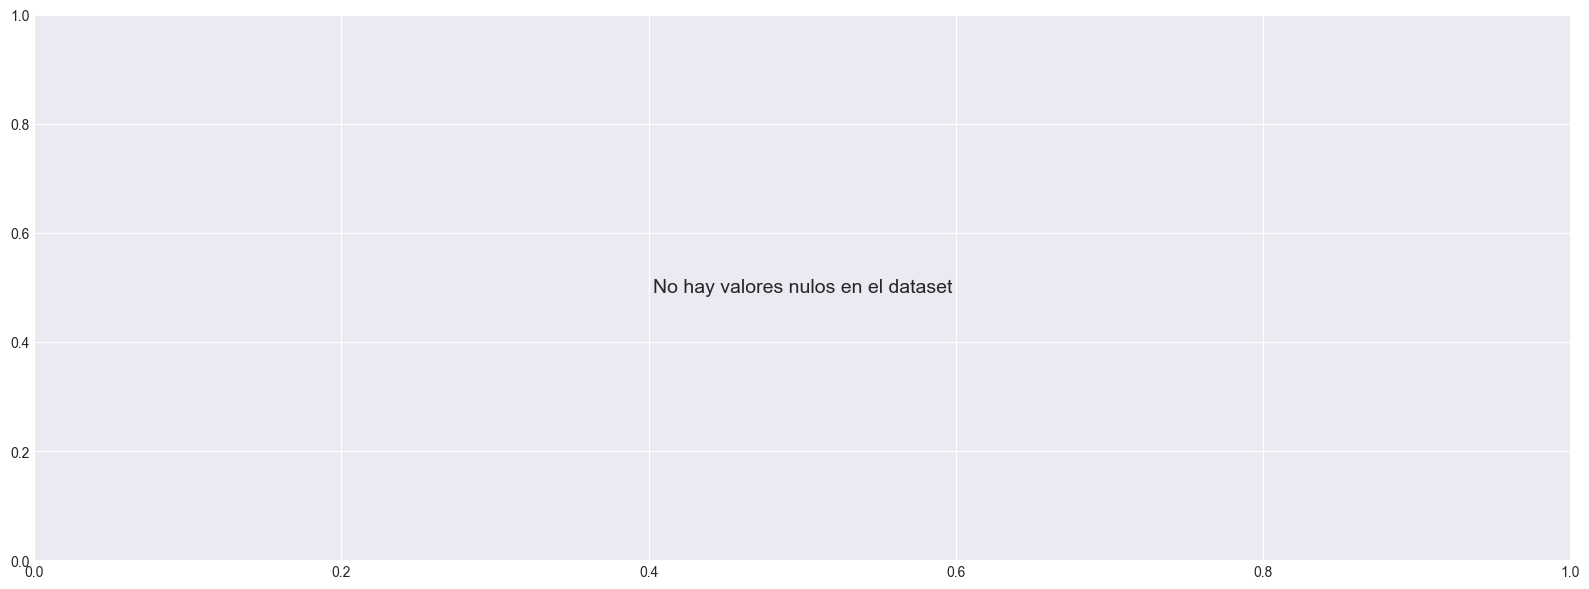

Figura guardada en: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\reports\figures\heatmap_nulos.png


In [ ]:
# Heatmap de nulos (missingno)
fig, ax = plt.subplots(figsize=(16, 6))

# Seleccionar columnas con nulos para visualizacion clara
cols_con_nulos = reporte_nulos.index.tolist()

if len(cols_con_nulos) > 0:
    try:
        msno.matrix(
            df_raw[cols_con_nulos].sample(min(500, len(df_raw)), random_state=42),
            ax=ax,
            color=(0.27, 0.52, 0.71)
        )
        plt.title('Patron de Valores Nulos (muestra de 500 registros)', fontsize=14, fontweight='bold')
    except Exception:
        # Fallback si missingno no disponible
        sns.heatmap(
            df_raw[cols_con_nulos].isnull().astype(int).head(100),
            cmap='Blues', cbar=False, ax=ax
        )
        plt.title('Mapa de Nulos (1=nulo, 0=presente)', fontsize=14, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'No hay valores nulos en el dataset',
            ha='center', va='center', fontsize=14, transform=ax.transAxes)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'heatmap_nulos.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Figura guardada en: {FIGURES_DIR / "heatmap_nulos.png"}')

## 4. Análisis de Duplicados

In [ ]:
# Columnas hashables (excluir listas/dicts que no son hashables)
_hashable_cols = [c for c in df_raw.columns
                  if df_raw[c].dropna().head(5).apply(lambda x: not isinstance(x, (list, dict))).all()]

# Duplicados por fila completa (solo en columnas hashables)
n_dup_filas = df_raw[_hashable_cols].duplicated().sum()
print(f'Filas completamente duplicadas (columnas hashables): {n_dup_filas:,}')

# Duplicados por AppID (clave natural)
if 'AppID' in df_raw.columns:
    n_dup_appid = df_raw['AppID'].duplicated().sum()
    print(f'AppIDs duplicados: {n_dup_appid:,}')
    if n_dup_appid > 0:
        print('Ejemplos de AppIDs duplicados:')
        dup_ids = df_raw[df_raw['AppID'].duplicated(keep=False)]
        print(dup_ids[['AppID', 'name']].head(10))

# Duplicados por nombre
if 'name' in df_raw.columns:
    n_dup_nombre = df_raw['name'].duplicated().sum()
    print(f'Nombres duplicados: {n_dup_nombre:,}')
    if n_dup_nombre > 0:
        print('Ejemplos de nombres duplicados:')
        dup_names = df_raw[df_raw['name'].duplicated(keep=False)]
        print(dup_names[['AppID', 'name']].head(10))


Filas completamente duplicadas (columnas hashables): 0
AppIDs duplicados: 0
Nombres duplicados: 1,156
Ejemplos de nombres duplicados:
       AppID                                           name
67    849178  Shadow of the Tomb Raider: Definitive Edition
108  2569500                                    Office Life
136  3225840                                     Wilderness
318  3427550                           Dating App Simulator
439   765240                                       Daydream
492  1116520                                  The Backrooms
499  2386620                                      Labyrinth
581  3076520                                            Dog
603  3535830                                 Anomaly Report
605   818390                                       The Deer


## 5. Identificación de Tipos de Variables

In [ ]:
def classify_columns(df: pd.DataFrame) -> dict:
    """Clasifica las columnas del DataFrame por tipo de variable.
    
    Args:
        df: DataFrame a clasificar
        
    Returns:
        Diccionario con listas de columnas por categoria.
    """
    classification = {
        'numericas_continuas': [],
        'numericas_discretas': [],
        'booleanas': [],
        'categoricas': [],
        'texto_libre': [],
        'listas': [],
        'diccionarios': [],
        'fechas': [],
        'identificadores': []
    }
    
    # Columnas conocidas como IDs
    id_keywords = ['id', 'appid', 'url', 'email', 'image']
    
    for col in df.columns:
        col_lower = col.lower()
        # Usar solo los primeros N valores no nulos para detectar el tipo (performance)
        series_sample = df[col].dropna().head(20)
        
        # Identificadores
        if any(kw in col_lower for kw in id_keywords):
            classification['identificadores'].append(col)
            continue
        
        # Booleanas
        if df[col].dtype == bool:
            classification['booleanas'].append(col)
            continue
        
        # Numericas
        if df[col].dtype in [np.int64, np.int32, np.float64, np.float32,
                              'Int64', 'Int32', 'Float64']:
            n_unique = df[col].nunique()
            if n_unique <= 20:
                classification['numericas_discretas'].append(col)
            else:
                classification['numericas_continuas'].append(col)
            continue
        
        # Listas y diccionarios (object con tipos complejos) - solo verificar primeros valores
        if df[col].dtype == object and len(series_sample) > 0:
            first_val = series_sample.iloc[0]
            if isinstance(first_val, list):
                classification['listas'].append(col)
                continue
            elif isinstance(first_val, dict):
                classification['diccionarios'].append(col)
                continue
        
        # Fechas (por nombre o por dtype)
        if hasattr(df[col], 'dt') or any(kw in col_lower for kw in ['date', 'fecha', 'time']):
            classification['fechas'].append(col)
            continue
        
        # Categoricas vs texto libre
        if df[col].dtype == object:
            n_unique = df[col].nunique()
            if n_unique <= 50 or (n_unique / max(len(df), 1) < 0.05):
                classification['categoricas'].append(col)
            else:
                classification['texto_libre'].append(col)
    
    return classification


tipos = classify_columns(df_raw)

for tipo, cols in tipos.items():
    if cols:
        print(f'\n{tipo.upper()} ({len(cols)} columnas):')
        for c in cols:
            print(f'  - {c}')



NUMERICAS_CONTINUAS (13 columnas):
  - price
  - dlc_count
  - metacritic_score
  - achievements
  - recommendations
  - user_score
  - positive
  - negative
  - average_playtime_forever
  - average_playtime_2weeks
  - median_playtime_forever
  - median_playtime_2weeks
  - peak_ccu

NUMERICAS_DISCRETAS (1 columnas):
  - required_age

BOOLEANAS (3 columnas):
  - windows
  - mac
  - linux

CATEGORICAS (2 columnas):
  - score_rank
  - discount

LISTAS (10 columnas):
  - supported_languages
  - full_audio_languages
  - packages
  - developers
  - publishers
  - categories
  - genres
  - screenshots
  - movies
  - tags

FECHAS (1 columnas):
  - release_date

IDENTIFICADORES (5 columnas):
  - AppID
  - header_image
  - support_url
  - support_email
  - metacritic_url


## 6. Limpieza del Dataset

### 6.1 Normalización de Tipos de Datos

In [ ]:
df = df_raw.copy()

# --- AppID como string (ya deberia serlo, pero por si acaso) ---
df['AppID'] = df['AppID'].astype(str).str.strip()

# --- Columnas booleanas ---
bool_cols = ['windows', 'mac', 'linux']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)

# --- Columnas numericas enteras ---
int_cols = ['positive', 'negative', 'metacritic_score', 'recommendations',
            'dlc_count', 'achievements', 'peak_ccu', 'required_age',
            'average_playtime_forever', 'average_playtime_2weeks',
            'median_playtime_forever', 'median_playtime_2weeks']

for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# --- Precio como float ---
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0.0)

print('Tipos normalizados correctamente.')
df[bool_cols + ['price'] + [c for c in int_cols if c in df.columns]].dtypes

Tipos normalizados correctamente.


windows                        bool
mac                            bool
linux                          bool
price                       float64
positive                      int64
negative                      int64
metacritic_score              int64
recommendations               int64
dlc_count                     int64
achievements                  int64
peak_ccu                      int64
required_age                  int64
average_playtime_forever      int64
average_playtime_2weeks       int64
median_playtime_forever       int64
median_playtime_2weeks        int64
dtype: object

### 6.2 Parseo de Fechas

In [ ]:
if 'release_date' in df.columns:
    # Limpiar fechas vacias o invalidas
    df['release_date'] = df['release_date'].replace({'': np.nan, 'Coming soon': np.nan, 'TBD': np.nan})
    
    # Parsear a datetime (manejar multiples formatos)
    df['release_date'] = pd.to_datetime(
        df['release_date'], 
        format='mixed', 
        dayfirst=False,
        errors='coerce'
    )
    
    # Extraer componentes de fecha
    df['release_year'] = df['release_date'].dt.year.astype('Int64')
    df['release_month'] = df['release_date'].dt.month.astype('Int64')
    df['release_quarter'] = df['release_date'].dt.quarter.astype('Int64')
    
    n_fechas_validas = df['release_date'].notna().sum()
    n_fechas_invalidas = df['release_date'].isna().sum()
    print(f'Fechas validas: {n_fechas_validas:,} ({n_fechas_validas/len(df)*100:.1f}%)')
    print(f'Fechas invalidas/nulas: {n_fechas_invalidas:,} ({n_fechas_invalidas/len(df)*100:.1f}%)')
    print()
    print(f'Rango de fechas: {df["release_date"].min()} a {df["release_date"].max()}')

Fechas validas: 122,611 (100.0%)
Fechas invalidas/nulas: 0 (0.0%)

Rango de fechas: 1997-06-30 00:00:00 a 2026-01-05 00:00:00


### 6.3 Expansión de Campos JSON Anidados

In [ ]:
# Las funciones extract_list_names y extract_tags_top están centralizadas en
# src/data/steam_transforms.py e importadas en la celda de setup.

# Expandir géneros
if 'genres' in df.columns:
    df['genres_str'] = df['genres'].apply(extract_list_names)
    df['genre_primary'] = df['genres_str'].apply(lambda x: x.split('|')[0] if x else 'Unknown')
    df['genre_count'] = df['genres_str'].apply(lambda x: len(x.split('|')) if x else 0)
    print(f'Generos unicos (primario): {df["genre_primary"].nunique()}')
    print(df['genre_primary'].value_counts().head(10))

print()

In [ ]:
# Expandir categorias
if 'categories' in df.columns:
    df['categories_str'] = df['categories'].apply(extract_list_names)
    df['has_multiplayer'] = df['categories_str'].str.contains('Multi-player', na=False, case=False)
    df['has_coop'] = df['categories_str'].str.contains('Co-op', na=False, case=False)
    df['has_singleplayer'] = df['categories_str'].str.contains('Single-player', na=False, case=False)
    print(f'Con multijugador: {df["has_multiplayer"].sum():,} ({df["has_multiplayer"].mean()*100:.1f}%)')
    print(f'Con co-op: {df["has_coop"].sum():,} ({df["has_coop"].mean()*100:.1f}%)')
    print(f'Con singleplayer: {df["has_singleplayer"].sum():,} ({df["has_singleplayer"].mean()*100:.1f}%)')

# Expandir developers y publishers
if 'developers' in df.columns:
    df['developers_str'] = df['developers'].apply(extract_list_names)
    df['developer_primary'] = df['developers_str'].apply(lambda x: x.split('|')[0] if x else 'Unknown')

if 'publishers' in df.columns:
    df['publishers_str'] = df['publishers'].apply(extract_list_names)
    df['publisher_primary'] = df['publishers_str'].apply(lambda x: x.split('|')[0] if x else 'Unknown')

# Expandir tags
if 'tags' in df.columns:
    df['tags_top5'] = df['tags'].apply(lambda x: extract_tags_top(x, 5))
    print(f'\nEjemplo de tags_top5:')
    print(df['tags_top5'].dropna().head(5).values)

Con multijugador: 20,294 (16.6%)
Con co-op: 11,044 (9.0%)
Con singleplayer: 108,003 (88.1%)



Ejemplo de tags_top5:
<ArrowStringArray>
[                                               '',
               'Adventure|Visual Novel|Anime|Cute',
 'Casual|Card Game|Solitaire|Puzzle|Hidden Object',
                                                '',
                                                '']
Length: 5, dtype: str


### 6.4 Tratamiento de Valores Nulos en Columnas Clave

In [ ]:
# Nombre: no puede estar vacio
if 'name' in df.columns:
    antes = len(df)
    df = df[df['name'].notna() & (df['name'] != '')].copy()
    print(f'Filas eliminadas por nombre vacio: {antes - len(df):,}')

# score_rank: llenar con string vacio si es nulo
if 'score_rank' in df.columns:
    df['score_rank'] = df['score_rank'].fillna('')

# website, support_url: llenar con vacio
for col in ['website', 'support_url', 'support_email', 'header_image', 'metacritic_url']:
    if col in df.columns:
        df[col] = df[col].fillna('')

# supported_languages: normalizar usando función centralizada del módulo
if 'supported_languages' in df.columns:
    df['supported_languages'] = df['supported_languages'].apply(parse_languages)
    df['n_languages'] = df['supported_languages'].apply(
        lambda x: len(x.split(',')) if x else 0
    )

# estimated_owners: normalizar
if 'estimated_owners' in df.columns:
    df['estimated_owners'] = df['estimated_owners'].fillna('0 - 0')

print('Tratamiento de nulos completado.')
print(f'Filas finales: {len(df):,}')

### 6.5 Detección y Tratamiento de Outliers en Variables Numéricas

In [ ]:
def detect_outliers_iqr(series: pd.Series) -> dict:
    """Detecta outliers usando el metodo IQR (rango intercuartilico).
    
    Args:
        series: Serie numerica a analizar.
        
    Returns:
        Diccionario con estadisticas de outliers.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return {
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower, 'upper_bound': upper,
        'n_outliers': len(outliers),
        'pct_outliers': len(outliers) / len(series) * 100
    }


numeric_cols_to_check = ['price', 'positive', 'negative', 'metacritic_score',
                          'average_playtime_forever', 'peak_ccu', 'achievements']

outlier_results = []
for col in numeric_cols_to_check:
    if col in df.columns:
        stats = detect_outliers_iqr(df[col])
        stats['columna'] = col
        outlier_results.append(stats)

outlier_df = pd.DataFrame(outlier_results).set_index('columna')
print('Analisis de Outliers (metodo IQR):')
outlier_df[['Q1', 'Q3', 'lower_bound', 'upper_bound', 'n_outliers', 'pct_outliers']].round(2)

Analisis de Outliers (metodo IQR):


,Q1,Q3,lower_bound,upper_bound,n_outliers,pct_outliers
columna,,,,,,
price,0.55,5.24,-6.48,12.28,9297,7.58
positive,0.00,37.00,-55.50,92.50,20797,16.96
negative,0.00,10.00,-15.00,25.00,20696,16.88
metacritic_score,0.00,0.00,0.00,0.00,4256,3.47
average_playtime_forever,0.00,0.00,0.00,0.00,26119,21.30
peak_ccu,0.00,0.00,0.00,0.00,19676,16.05
achievements,0.00,19.00,-28.50,47.50,8433,6.88


### 6.6 Eliminación de Columnas de Bajo Valor

In [ ]:
# Columnas de alto contenido de HTML o muy especificas que no aportan al analisis
cols_to_drop = [
    'detailed_description',  # HTML largo, se usa short_description
    'about_the_game',        # Similar a detailed_description
    'header_image',          # URL de imagen
    'website',               # URL
    'support_url',           # URL
    'support_email',         # Email
    'metacritic_url',        # URL
    'packages',              # Estructura muy anidada
    'screenshots',           # URLs de imagenes
    'movies',                # URLs de videos
    # Columnas originales reemplazadas por expandidas
    'genres',
    'categories', 
    'developers',
    'publishers',
    'tags'
]

cols_existentes_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_existentes_to_drop)

print(f'Columnas eliminadas: {len(cols_existentes_to_drop)}')
print(f'Columnas restantes: {df.shape[1]}')
print(f'Shape final: {df.shape}')

Columnas eliminadas: 15
Columnas restantes: 44
Shape final: (122610, 44)


## 7. Verificación Final y Guardado

In [ ]:
print('=== REPORTE FINAL DEL DATASET LIMPIO ===')
print(f'Shape: {df.shape}')
print(f'Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print()

# Nulos restantes
nulos_finales = df.isnull().sum()
nulos_finales = nulos_finales[nulos_finales > 0]
if len(nulos_finales) > 0:
    print('Nulos restantes:')
    print(nulos_finales)
else:
    print('Sin valores nulos en columnas principales.')

print()
print('Columnas del dataset limpio:')
for col in sorted(df.columns):
    print(f'  {col}: {df[col].dtype}')

=== REPORTE FINAL DEL DATASET LIMPIO ===
Shape: (122610, 44)
Memoria: 117.48 MB

Sin valores nulos en columnas principales.

Columnas del dataset limpio:
  AppID: str
  achievements: int64
  average_playtime_2weeks: int64
  average_playtime_forever: int64
  categories_str: str
  developer_primary: str
  developers_str: str
  discount: object
  dlc_count: int64
  estimated_owners: str
  full_audio_languages: object
  genre_count: int64
  genre_primary: str
  genres_str: str
  has_coop: bool
  has_multiplayer: bool
  has_singleplayer: bool
  linux: bool
  mac: bool
  median_playtime_2weeks: int64
  median_playtime_forever: int64
  metacritic_score: int64
  n_languages: int64
  name: str
  negative: int64
  notes: str
  peak_ccu: int64
  positive: int64
  price: float64
  publisher_primary: str
  publishers_str: str
  recommendations: int64
  release_date: datetime64[us]
  release_month: Int64
  release_quarter: Int64
  release_year: Int64
  required_age: int64
  reviews: str
  score_rank

In [ ]:
# Guardar dataset procesado
today = date.today().isoformat()
output_path_csv = PROCESSED_DATA_DIR / f'steam_games_clean_{today}.csv'
output_path_parquet = PROCESSED_DATA_DIR / f'steam_games_clean_{today}.parquet'

# Convertir columnas de tipo object complejo a string antes de guardar
df_to_save = df.copy()
for col in df_to_save.columns:
    if df_to_save[col].dtype == object:
        # Convertir siempre columnas object a str (puede contener mixed types o listas)
        df_to_save[col] = df_to_save[col].apply(
            lambda x: str(x) if not isinstance(x, str) else x
        )

# Guardar como CSV
df_to_save.to_csv(output_path_csv, index=False, encoding='utf-8')
print(f'Dataset guardado en CSV: {output_path_csv}')
print(f'Tamano del archivo: {output_path_csv.stat().st_size / 1024**2:.2f} MB')

# Guardar como Parquet (mas eficiente para dataset grande)
try:
    df_to_save.to_parquet(output_path_parquet, index=False)
    print(f'Dataset guardado en Parquet: {output_path_parquet}')
    print(f'Tamano del archivo: {output_path_parquet.stat().st_size / 1024**2:.2f} MB')
except Exception as e:
    logger.warning(f'No se pudo guardar como Parquet: {e}')

print(f'\nTotal de juegos en dataset limpio: {len(df_to_save):,}')


Dataset guardado en CSV: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\processed\steam_games_clean_2026-02-11.csv
Tamano del archivo: 77.30 MB


Dataset guardado en Parquet: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\processed\steam_games_clean_2026-02-11.parquet
Tamano del archivo: 32.49 MB

Total de juegos en dataset limpio: 122,610


## 8. Resumen Ejecutivo

### Lo que se hizo:

1. **Carga**: Dataset JSON de Steam con ~122,000 juegos cargado y convertido a DataFrame estructurado
2. **Inspección**: Identificadas columnas de tipo numerico, booleano, lista, diccionario y texto libre
3. **Nulos**: Analizado el patron de valores nulos; columnas de descripcion tienen mayor porcentaje
4. **Duplicados**: Verificada unicidad de AppID como clave natural
5. **Tipos**: Normalizados tipos de datos (bool, int, float, datetime)
6. **Fechas**: `release_date` parseada a datetime, extraidas columnas `year`, `month`, `quarter`
7. **Campos anidados**: `genres`, `categories`, `developers`, `publishers`, `tags` expandidos a strings delimitados por `|`
8. **Features derivadas**: `has_multiplayer`, `has_coop`, `has_singleplayer`, `genre_primary`, `n_languages`
9. **Outliers**: Identificados en variables como `price`, `positive`, `peak_ccu`
10. **Guardado**: Dataset limpio en `data/processed/steam_games_clean_YYYY-MM-DD.csv` y `.parquet`

### Siguiente paso:
Cargar `data/processed/steam_games_clean_YYYY-MM-DD.csv` en el notebook `02_transformaciones_features_steam.ipynb` para feature engineering.